# Gradient-based inference of a transmission string

In this tutorial we take a look at how to fit a light curve with a gradient-based Markov chain Monte Carlo (MCMC) approach, known as Hamiltonian Monte Carlo (HMC), and infer a distribution of transmission strings. HMC has the advantage that is reduces the correlation between successive samples, thereby enabling more efficient sampling and lower utilisation of computation energy and time. As in the previous tutorial, let us start by simulating a transit light curve for a known 7-parameter transmission string.

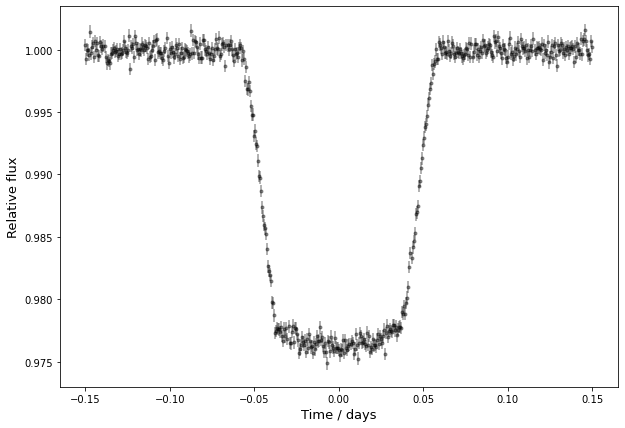

In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from harmonica import HarmonicaTransit


np.random.seed(12)

times = np.linspace(-0.15, 0.15, 500)
r_mean = np.array([0.15])
r_dev = np.random.uniform(-0.1, 0.1, size=6)
injected_r = np.concatenate([r_mean, r_dev * r_mean])

ht = HarmonicaTransit(times)
ht.set_orbit(t0=0., period=4., a=11., inc=87. * np.pi / 180.)
ht.set_stellar_limb_darkening(np.array([0.027, 0.246]), limb_dark_law='quadratic')
ht.set_planet_transmission_string(injected_r)

theta = np.linspace(-np.pi, np.pi, 1000)
injected_transmission_string = ht.get_planet_transmission_string(theta)

flux_sigma = 500.e-6 * np.ones(times.shape[0])
flux_errs = np.random.normal(loc=0., scale=flux_sigma, size=times.shape[0])
observed_fluxes = ht.get_transit_light_curve() + flux_errs

plt.figure(figsize=(10, 7))
plt.errorbar(times, observed_fluxes, yerr=flux_sigma, fmt=".k", alpha=0.4)
plt.xlabel('Time / days', fontsize=13)
plt.ylabel('Relative flux', fontsize=13)
plt.show()

This transit light curve corresponds to the following transmission string:

r = 0.150-0.010cos(t)+0.007sin(t)-0.007cos(2t)+0.001sin(2t)-0.015cos(3t)+0.013sin(3t)


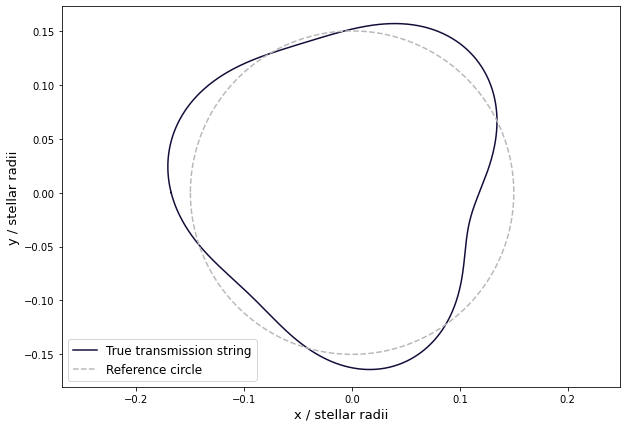

In [2]:
print("r = {0:.3f}{1:+.3f}cos(t){2:+.3f}sin(t)"
      "{3:+.3f}cos(2t){4:+.3f}sin(2t)"
      "{5:+.3f}cos(3t){6:+.3f}sin(3t)".format(*injected_r))

plt.figure(figsize=(10, 7))
plt.gca().set_aspect("equal", "datalim")
plt.plot(injected_transmission_string * np.cos(theta), 
         injected_transmission_string * np.sin(theta), 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(injected_r[0] * np.cos(theta), injected_r[0] * np.sin(theta), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("x / stellar radii", fontsize=13)
plt.ylabel("y / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

Now you can apply Harmonica and sample the transmission string parameters. To do this we make use of the HMC code, $\texttt{numpyro}$. This code requires $\texttt{jax}$ in order to compute derivatives. In order to be compatible with these requirements, we provide a subpackage, [harmonica.jax](<../api/harmonica.jax.html>), which can be incorporated into a numpyro model as follows:

In [3]:
import jax
import numpyro
import jax.numpy as jnp
import numpyro.distributions as dist
from harmonica.jax import harmonica_transit_quad_ld
from numpyro.infer import MCMC, NUTS, init_to_median


def numpyro_model(t, f_obs=None):
    # Zeroth-order planet radius: r0.
    r0 = numpyro.sample('r0', dist.Uniform(0.15 - 0.05, 0.15 + 0.05))

    # Higher-order radius harmonics: rn/r0.
    rn_frac = numpyro.sample('rn_frac', dist.Normal(0.0, 0.1), sample_shape=(6,))

    # Transmission string parameter vector.
    r = numpyro.deterministic('r', jnp.concatenate([jnp.array([r0]), rn_frac * r0]))

    # Model evaluation: this is our custom JAX primitive.
    fs = harmonica_transit_quad_ld(
        t, t0=0., period=4., a=11., inc=87. * np.pi / 180., u1=0.027, u2=0.246, r=r)

    # Condition on the observations.
    numpyro.sample('obs', dist.Normal(fs, flux_sigma), obs=f_obs)


nuts_kernel = NUTS(numpyro_model, dense_mass=True, adapt_mass_matrix=True,
                   max_tree_depth=7, target_accept_prob=0.75,
                   init_strategy=init_to_median())

hmc = MCMC(nuts_kernel, num_warmup=200, num_samples=500, 
           num_chains=2, chain_method="sequential", progress_bar=True)

hmc.run(jax.random.PRNGKey(2), times, f_obs=observed_fluxes)

sample: 100%|███████████████████████████████████| 700/700 [02:25<00:00,  4.82it/s, 7 steps of size 4.17e-01. acc. prob=0.90]


For this example, the runtime of this method is now ~4 minutes. Compared to the [basic inference](<basic_mcmc_transmission_string.html>) tutorial, this represents a good efficiency improvement for a similar number of effective samples.

Next, you can check the key metrics of this run and take a look at the posterior parameter distributions using $\texttt{arviz}$ and $\texttt{corner}$, respectively.

In [4]:
import arviz as az


numpyro_data = az.from_numpyro(hmc)
az.summary(numpyro_data, var_names=['r'], round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r[0],0.15018,0.00040,0.14940,0.15084,0.00001,0.00001,953.40429,694.18954,1.00468
r[1],-0.00783,0.00126,-0.01038,-0.00563,0.00004,0.00003,1180.15532,948.02794,0.99826
r[2],0.00691,0.00159,0.00386,0.00980,0.00005,0.00004,1170.08260,699.29110,1.00211
r[3],-0.00808,0.00554,-0.01870,0.00179,0.00019,0.00015,889.68144,618.98218,0.99909
r[4],0.00203,0.00192,-0.00108,0.00600,0.00007,0.00005,847.36444,721.85776,0.99874
r[5],-0.01326,0.00508,-0.02277,-0.00377,0.00020,0.00015,673.15398,528.34178,1.00432
r[6],0.01209,0.00363,0.00488,0.01850,0.00014,0.00010,622.63127,678.51718,1.00031


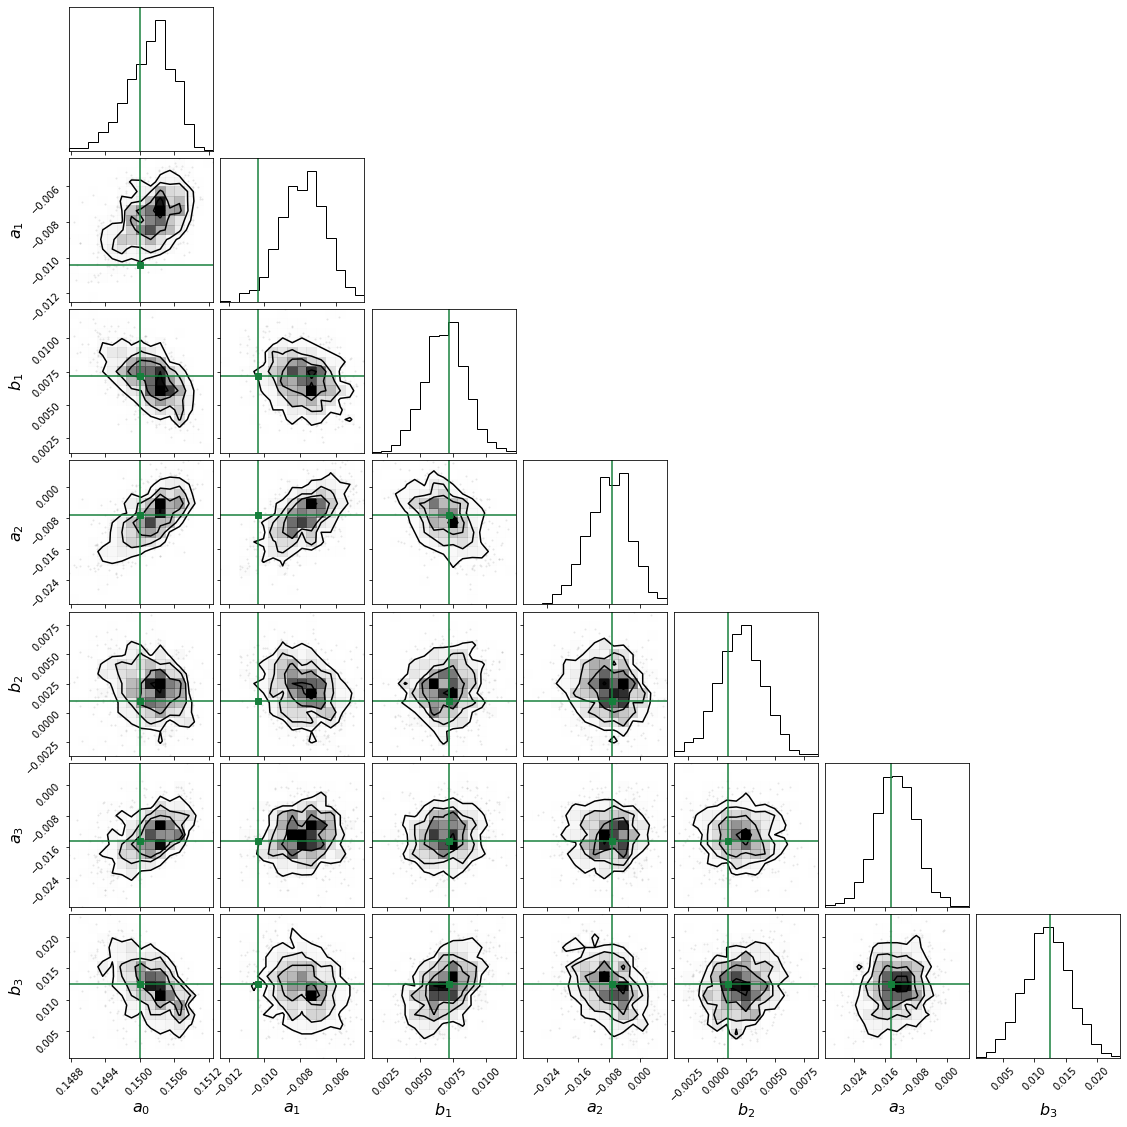

In [5]:
import corner


hmc_r_samples = np.array(hmc.get_samples()['r'])
figure = corner.corner(hmc_r_samples, truths=injected_r, 
                       truth_color=cm.BuGn(0.8), bins=15,
                       label_kwargs={"fontsize": 16},
                       labels=["$a_0$", "$a_1$", "$b_1$", "$a_2$", 
                               "$b_2$", "$a_3$", "$b_3$"])
plt.show()

You can sample the posteriors and plot realisations of the fitted transit light curve:

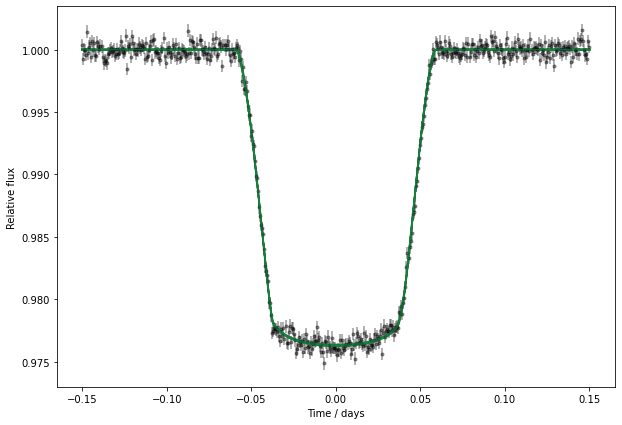

In [6]:
sample_idxs = np.random.randint(0, len(hmc_r_samples), 150)

plt.figure(figsize=(10, 7))
plt.errorbar(times, observed_fluxes, yerr=flux_sigma, fmt=".k", alpha=0.4, zorder=1)
for r_sample in hmc_r_samples[sample_idxs]:
    ht.set_planet_transmission_string(r_sample)
    plt.plot(times, ht.get_transit_light_curve(), c=cm.BuGn(0.8), alpha=0.03, zorder=2)
plt.xlabel('Time / days', fontsize=13)
plt.ylabel('Relative flux', fontsize=13)
plt.show()

And here are sampled transmission strings:

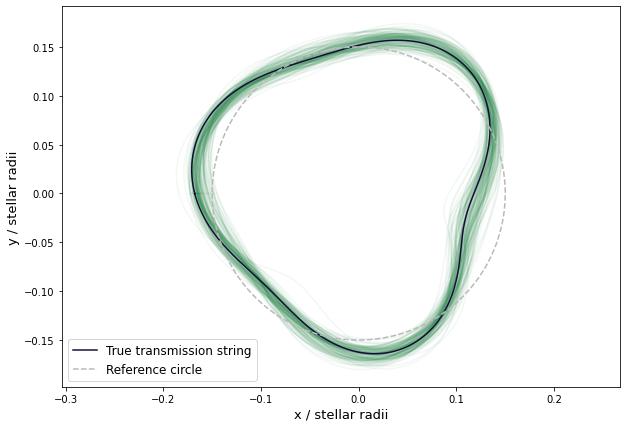

In [7]:
plt.figure(figsize=(10, 7))
plt.gca().set_aspect("equal", "datalim")
for r_sample in hmc_r_samples[sample_idxs]:
    ht.set_planet_transmission_string(r_sample)
    plt.plot(ht.get_planet_transmission_string(theta) * np.cos(theta), 
             ht.get_planet_transmission_string(theta) * np.sin(theta), 
             c=cm.BuGn(0.8), alpha=0.05)
plt.plot(injected_transmission_string * np.cos(theta), 
         injected_transmission_string * np.sin(theta), 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(injected_r[0] * np.cos(theta), injected_r[0] * np.sin(theta), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("x / stellar radii", fontsize=13)
plt.ylabel("y / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

In polar coordinates:

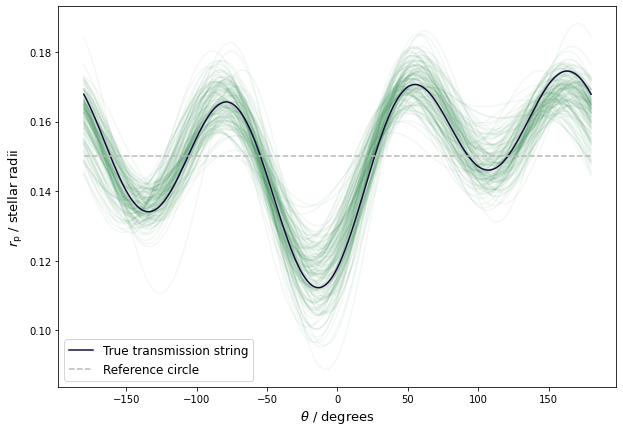

In [8]:
plt.figure(figsize=(10, 7))
for r_sample in hmc_r_samples[sample_idxs]:
    ht.set_planet_transmission_string(r_sample)
    plt.plot(theta * 180. / np.pi, ht.get_planet_transmission_string(theta), 
             c=cm.BuGn(0.8), alpha=0.05)
plt.plot(theta * 180. / np.pi, injected_transmission_string, 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(theta * 180. / np.pi, injected_r[0] * np.ones(theta.shape[0]), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("$\\theta$ / degrees", fontsize=13)
plt.ylabel("$r_{\\rm{p}}$ / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

From these samples, you can estimate the inferred distribution of transmission strings. Here you can see the injected transmission string is nicely recovered.

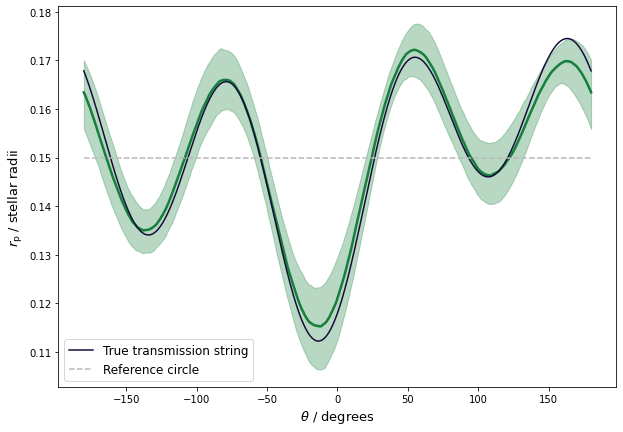

In [9]:
# Sample HMC transmission string parameter distributions.
ht.set_planet_transmission_string(hmc_r_samples)
ts_samples = ht.get_planet_transmission_string(theta)

# Get 16th, 50th, 84th percentiles.
ts_16, ts_50, ts_84 = np.percentile(ts_samples, [16., 50., 84.], axis=0)

plt.figure(figsize=(10, 7))
plt.plot(theta * 180. / np.pi, ts_50, c=cm.BuGn(0.8), lw=2.5)
plt.fill_between(theta * 180. / np.pi, ts_16, ts_84, color=cm.BuGn(0.8), alpha=0.3)
plt.plot(theta * 180. / np.pi, injected_transmission_string, 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(theta * 180. / np.pi, injected_r[0] * np.ones(theta.shape[0]), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("$\\theta$ / degrees", fontsize=13)
plt.ylabel("$r_{\\rm{p}}$ / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()